拡散モデル(DDPM)が徐々にノイズ除去をしながら画像を生成する過程に着想を得て、毎ステップごとにノイズを加えることで、より多様な画像を生成することや局所解に陥ることの回避を考えた。

`161.png`を使った実験ではあまり変わっているようには見えない。しかし、やや歪みが大きく形が多様であるように見えるかもしれない。

具体的には、キリンの模様が付けやすくなった気がする。
`I3_TextureSynthesis/algorithm_3_2.ipynb`の2番目の実験と、このノートブックの2番目の実験を比較すると、キリンの模様が付けやすくなったことがわかる。

texture image size is (64, 64, 3)


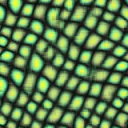

iter 1: loss:1414.473368326823
iter 2: loss:1358.2965291341145
iter 3: loss:1281.1764526367188
iter 4: loss:1249.102518717448
iter 5: loss:1225.298095703125
iter 6: loss:1207.466776529948
iter 7: loss:1188.6708577473958
iter 8: loss:1171.8484497070312
iter 9: loss:1164.4423828125
iter 10: loss:1155.4927368164062
iter 11: loss:1148.727783203125
iter 12: loss:1144.3539428710938
iter 13: loss:1140.1787923177083
iter 14: loss:1138.2479654947917
iter 15: loss:1138.0178629557292
iter 16: loss:1138.5967203776042
iter 17: loss:1139.0612386067708
iter 18: loss:1136.9036051432292
iter 19: loss:1133.7406616210938
iter 20: loss:1133.7089233398438
iter 21: loss:1132.2525634765625
iter 22: loss:1133.037821451823
iter 23: loss:1132.0303344726562
iter 24: loss:1131.2127685546875
iter 25: loss:1130.7519938151042
iter 26: loss:1131.267354329427
iter 27: loss:1130.254862467448
iter 28: loss:1129.0731811523438
iter 29: loss:1128.5387573242188
iter 30: loss:1128.2820638020833
iter 31: loss:1128.98173014322

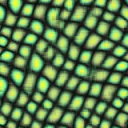

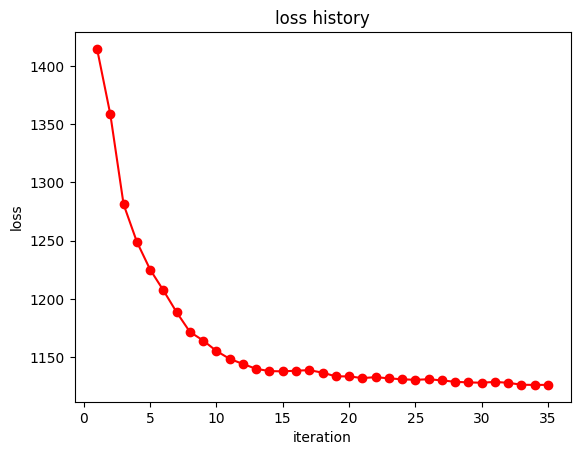

In [13]:
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from PIL import Image


### variables
path_to_texture_img = "sample_images/161.jpg"
target_width = 128
neighbor_width = 16
max_iter = 50


texture = cv2.imread(path_to_texture_img)
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
print("texture image size is", texture.shape)

target = np.random.randint(0, 256, size=(target_width, target_width, 3), dtype=np.uint8)
img_display = display(Image.fromarray(target), display_id=True)

indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
x, y = np.meshgrid(indices, indices)
target_anchors = np.column_stack((y.ravel(), x.ravel()))

texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
texture_anchors[:, 0] = np.random.randint(
    0, texture.shape[0] - neighbor_width, size=len(target_anchors)
)
texture_anchors[:, 1] = np.random.randint(
    0, texture.shape[1] - neighbor_width, size=len(target_anchors)
)


loss_history = []

for iter in range(max_iter):
    # update target to argmin(E(target, texture))
    ref_for_pixel = [[] for _ in range(target_width**2)]

    for target_anchor, texture_anchor in zip(target_anchors, texture_anchors):
        y, x = target_anchor
        yy, xx = texture_anchor
        for i in range(neighbor_width):
            for j in range(neighbor_width):
                ref_for_pixel[(y + i) * target_width + (x + j)].append(
                    texture[yy + i, xx + j]
                )

    loss = 0
    for y in range(len(target)):
        for x in range(len(target)):
            target[y, x] = np.mean(ref_for_pixel[y * target_width + x], axis=0)
            loss += np.sum((ref_for_pixel[y * target_width + x] - target[y, x]) ** 2)

    mse = loss / (target.shape[0] * target.shape[1]) / 3
    print(f"iter {iter+1}: loss:{mse}")
    loss_history.append(mse)
    img_display.update(Image.fromarray(target))

    # update texture reference points
    texture_anchors_prev = texture_anchors.copy()

    for i, target_anchor in enumerate(target_anchors):
        y, x = target_anchor
        result = cv2.matchTemplate(
            texture,
            target[y : y + neighbor_width, x : x + neighbor_width, :],
            method=cv2.TM_SQDIFF,
        )
        _, _, min_loc, _ = cv2.minMaxLoc(result)
        texture_anchors[i] = np.array([min_loc[1], min_loc[0]])

    if np.all(texture_anchors == texture_anchors_prev):
        break

    # add noise here
    if iter < max_iter * 0.8:
        noise = np.random.randint(0, 256, size=(target_width, target_width, 3), dtype=np.uint8)
        target = cv2.addWeighted(target, iter / (max_iter * 0.8), noise, 1 - (iter / max_iter * 0.8), 0)
        img_display.update(Image.fromarray(target))

display(Image.fromarray(target))

now = datetime.now()
now = now.strftime("%Y%m%d%H%M%S")
Image.fromarray(target).save(f"synthesized_texture{now}.png")

plt.plot(range(1, len(loss_history) + 1), loss_history, "ro-")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("loss history")
plt.show()

texture image size is (32, 32, 3)


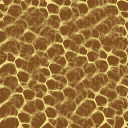

iter 1: loss:1483.2176717122395
iter 2: loss:1257.6729125976562
iter 3: loss:1184.929178873698
iter 4: loss:1129.703877766927
iter 5: loss:1088.767354329427
iter 6: loss:1063.7428588867188
iter 7: loss:1044.3436482747395
iter 8: loss:1032.447733561198
iter 9: loss:1022.9659220377604
iter 10: loss:1017.4850667317709
iter 11: loss:1010.1918538411459
iter 12: loss:1005.9780883789062
iter 13: loss:1000.982666015625
iter 14: loss:998.467529296875
iter 15: loss:997.9204508463541
iter 16: loss:996.7534586588541


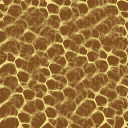

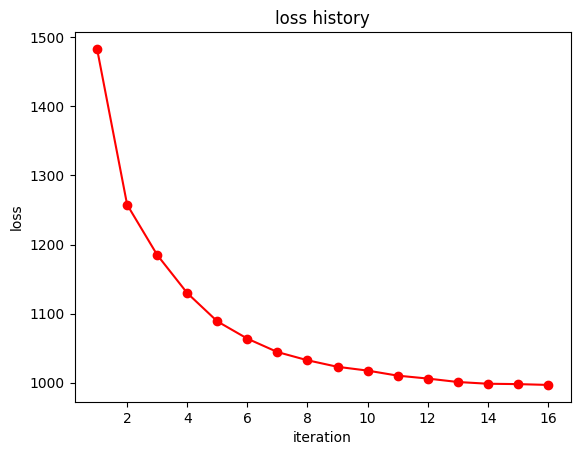

In [11]:
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from PIL import Image


### variables
path_to_texture_img = "sample_images/kirin_64.jpg"
target_width = 128
neighbor_width = 16
max_iter = 50


texture = cv2.imread(path_to_texture_img)
texture = cv2.cvtColor(texture, cv2.COLOR_BGR2RGB)
texture = cv2.resize(texture, (32, 32))
print("texture image size is", texture.shape)

target = np.random.randint(0, 256, size=(target_width, target_width, 3), dtype=np.uint8)
img_display = display(Image.fromarray(target), display_id=True)

indices = np.arange(0, target_width - neighbor_width + 1, neighbor_width // 4)
x, y = np.meshgrid(indices, indices)
target_anchors = np.column_stack((y.ravel(), x.ravel()))

texture_anchors = np.zeros((len(target_anchors), 2), dtype=int)
texture_anchors[:, 0] = np.random.randint(
    0, texture.shape[0] - neighbor_width, size=len(target_anchors)
)
texture_anchors[:, 1] = np.random.randint(
    0, texture.shape[1] - neighbor_width, size=len(target_anchors)
)


loss_history = []

for iter in range(max_iter):
    # update target to argmin(E(target, texture))
    ref_for_pixel = [[] for _ in range(target_width**2)]

    for target_anchor, texture_anchor in zip(target_anchors, texture_anchors):
        y, x = target_anchor
        yy, xx = texture_anchor
        for i in range(neighbor_width):
            for j in range(neighbor_width):
                ref_for_pixel[(y + i) * target_width + (x + j)].append(
                    texture[yy + i, xx + j]
                )

    loss = 0
    for y in range(len(target)):
        for x in range(len(target)):
            target[y, x] = np.mean(ref_for_pixel[y * target_width + x], axis=0)
            loss += np.sum((ref_for_pixel[y * target_width + x] - target[y, x]) ** 2)

    mse = loss / (target.shape[0] * target.shape[1]) / 3
    print(f"iter {iter+1}: loss:{mse}")
    loss_history.append(mse)
    img_display.update(Image.fromarray(target))

    # update texture reference points
    texture_anchors_prev = texture_anchors.copy()

    for i, target_anchor in enumerate(target_anchors):
        y, x = target_anchor
        result = cv2.matchTemplate(
            texture,
            target[y : y + neighbor_width, x : x + neighbor_width, :],
            method=cv2.TM_SQDIFF,
        )
        _, _, min_loc, _ = cv2.minMaxLoc(result)
        texture_anchors[i] = np.array([min_loc[1], min_loc[0]])

    if np.all(texture_anchors == texture_anchors_prev):
        break

    # add noise here
    if iter < max_iter * 0.8:
        noise = np.random.randint(0, 256, size=(target_width, target_width, 3), dtype=np.uint8)
        target = cv2.addWeighted(target, iter / (max_iter * 0.8), noise, 1 - (iter / max_iter * 0.8), 0)
        img_display.update(Image.fromarray(target))

display(Image.fromarray(target))

now = datetime.now()
now = now.strftime("%Y%m%d%H%M%S")
Image.fromarray(target).save(f"synthesized_texture{now}.png")

plt.plot(range(1, len(loss_history) + 1), loss_history, "ro-")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("loss history")
plt.show()

In [16]:
ine = cv2.imread("sample_images/ine.jpeg")
ine = cv2.resize(ine, (64, 64))
cv2.imwrite("sample_images/ine_64.jpg", ine)

True